#  DTI-derived metrics (FA, MD, AD, RD) within FS-segmented ROIs

BMED360-2021  `05-dmr-dti-feature-extraction-roi-wise.ipynb`

(assuming the `02-dmri-find-affine-fs-brainmask2dwi.ipynb` and `03-dmri-reconstruction-dti.ipynb` and `04-dmri-do-affine-reg-anat2dwi.ipynb` notebooks have been executed)

<a href="https://colab.research.google.com/github/computational-medicine/BMED360-2021/blob/main/Lab3-diffusion-MRI/05-dmr-dti-feature-extraction-roi-wise.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Learning objectives


**Check [FreeSurferColorLUT.txt](https://surfer.nmr.mgh.harvard.edu/fswiki/FsTutorial/AnatomicalROI/FreeSurferColorLUT) for the ROI-label for the different regions (left and right hemisphere)**

TODO


### For using Colab
**--> (some of) the following libraries must be `pip installed` (i.e. uncommet these among the following pip commands):**

In [1]:
#!pip install gdown
#!pip install nilearn
#!pip install dipy

**Download a data file from Google Drive using gdown** (https://github.com/wkentaro/gdown)

In [2]:
import gdown
import shutil
import sys
import os
from os.path import expanduser, join, basename, split
import glob
import shutil
import platform

Check your platform for running this notebook

In [3]:
if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install-win10')

OK, you are running on MacOS (Darwin Kernel Version 20.4.0: Fri Mar  5 01:14:14 PST 2021; root:xnu-7195.101.1~3/RELEASE_X86_64)


In [4]:
cwd = os.getcwd()

In [5]:
working_dir = join(cwd, 'data')
bids_dir = '%s/bids_bg_bmed360' % (working_dir)
dmri_res = '%s/dmri_results' % (working_dir)

In [6]:
# Download zip-file if ./data does not exist (as when running in Colab)

if os.path.isdir(working_dir) == False:
    
    ## Download data.zip for Google Drive            
    # https://drive.google.com/file/d/1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO/view?usp=sharing
    file_id = '1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = './data.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./data`
    shutil.unpack_archive(output, '.')
    
    ## Delete the `data.zip` file
    os.remove(output)
else:
    print(f'./data  exists already!')

./data  exists already!


In [7]:
# Download zip-file if ./data/dmri_results does not exist (as when running in Colab)

if os.path.isdir(dmri_res) == False:
    
    ## Download dmri_results.zip for Google Drive            
    # https://drive.google.com/file/d/1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO/view?usp=sharing
    file_id = '1wu5pzAcE2hyZymq-IzuzKYGK_lMYbnJy'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = 'dmri_results.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./data/dmri_results`
    shutil.unpack_archive(output, './data/')
    
    ## Delete the `dmri_results.zip` file
    os.remove(output)
else:
    print(f'./data/dmri_results  exists already!')

./data/dmri_results  exists already!


## Import libraries

In [8]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from os.path import expanduser, join, basename, split
import time
from dipy.io.image import save_nifti

In [9]:
def get_dti_features_from_roi(inpdir, sub, ses, roi_name, roi_num, outdir):
    r"""
    Extraction of DTI-derived featurevalues, i.e. FA, MD, AD, RD from a given antomical region, named 'roi_name'
    and numbered by Freesurfer as 'roi_num' with respect to the coregistered wmparc segmented image for 
    given subject ('sub') and session ('ses' = 1) 

    Parameters
    ----------
    inpdir     : input directory e.g. inpdir = 'data/dmri_results' where the moving files 
                   from Freesurfer segmentation mapped to T1w native space are stored.
    sub        : subject id, e.g. 102 for sub-102
    ses        : session number, e.g. 1 for ses-1
    roi_name   : name of a (white matter) region in wmparc, e.g. 'wm-lh-insula'
    roi_num    : number of that region according to the Freesurfer LUT, e.g. 3035
    outdir     : output directory e.g. outdir = inpdir, where resulting ... are stored,

    Returns
    -------
    meas_name  : list of DTI-derived features, for now ['fa', 'md', 'ad', 'rd']
    meas_num   : number of voxels in the named 3D ROI region (same accross all features)
    meas_val   : the feature values of each feature i in ['fa', 'md', 'ad', 'rd']


    Notes
    -----

    """
    
    # Preparations
    
    # Load WMPARC: 
    wmparc_fn = join(inpdir, 'sub_%d_tp%d_wmparc_in_native_space_aff_to_dwi_S0_mean.nii.gz' % (sub, ses))
    wmparc_img= nib.load(wmparc_fn)
    wmparc_data = wmparc_img.get_fdata()
    wmparc_affine = wmparc_img.affine
    
    #a = wmparc_data.flatten()
    #unique, counts = np.unique(a, return_counts=True)
    #dict(zip(unique, counts))
    
    roi = np.where(wmparc_data == roi_num)
    roi_flatten = np.where(wmparc_data.flatten() == roi_num)
    
    # Metrics from DTI in native DWI space
    dti_metrics = ['fa', 'md', 'ad', 'rd']
    meas_name = []
    meas_num = []
    meas_val = []
    for i, meas in enumerate(dti_metrics):
        fname = join(inpdir, 'sub_%d_tp%d_dwi_brainmask_tensor_%s.nii.gz' % (sub, ses, meas))
        meas_img= nib.load(fname)
        meas_data = meas_img.get_fdata()
        meas_affine = meas_img.affine
        
        meas_data_flatten = meas_data.flatten()
        
        meas_name.append(meas)
        meas_num.append(len(roi_flatten[0]))
        meas_val.append(meas_data_flatten[roi_flatten])
        
        #plt.hist(meas_val[i],bins=50)
        #plt.title('sub-%d | %s | %s | n=%d' % (sub, roi_name, meas_name[i], len(roi_flatten[0])))
        #plt.show()
        
    
    #fig = plt.figure(figsize = [14, 12])
    #for i, meas in enumerate(dti_metrics):
    #    plt.subplot(2,2,i+1)
    #    plt.hist(meas_val[i],bins=50, color='black')
    #    plt.title('sub-%d | %s | %s | n=%d | median=%.5f' %
    #              (sub, roi_name, meas_name[i].upper(), len(roi_flatten[0]), np.median(meas_val[i])))
    #plt.show()
    #fig.savefig('%s/tmp/FIGURES/sub_%d_wmparc_%s_dti_features.png' % (home, sub, roi_name),
    #       transparent=False, dpi=300, bbox_inches="tight")
    
    return dti_metrics, meas_name, meas_num, meas_val


In [10]:
# get_dti_features_from_roi?

In [11]:
inp_dir = dmri_res 
outp_dir = inp_dir

### Test the function

In [12]:
roi_name = 'wm-lh-insula'
roi_num = 3035
sub = 102
ses = 1

In [13]:
%%time
dti_metrics, meas_name, meas_num, meas_val = \
get_dti_features_from_roi(inp_dir, sub, ses, roi_name, roi_num, outp_dir)

CPU times: user 92.7 ms, sys: 32.6 ms, total: 125 ms
Wall time: 124 ms


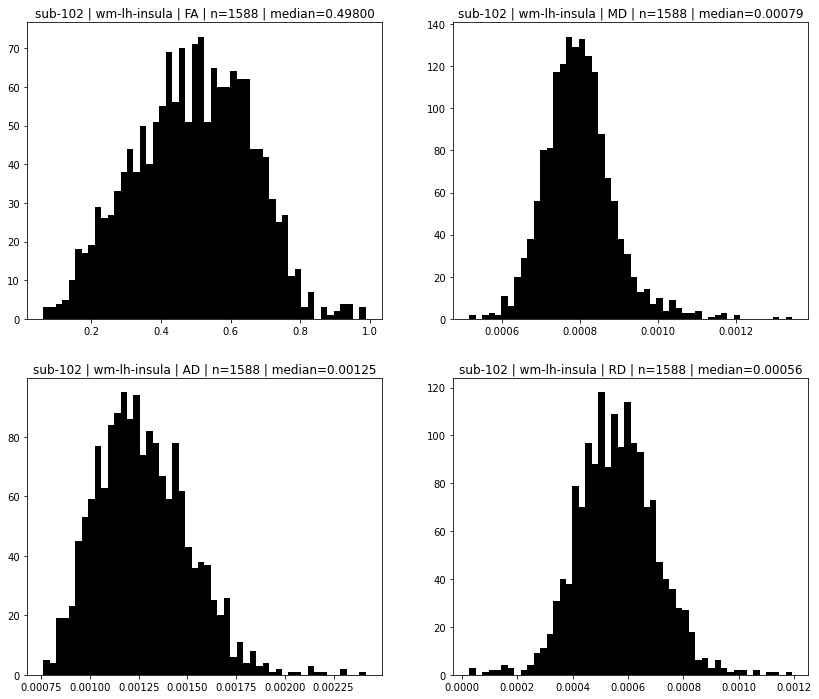

In [14]:
fig = plt.figure(figsize = [14, 12])
for i, meas in enumerate(dti_metrics):
    plt.subplot(2,2,i+1)
    plt.hist(meas_val[i],bins=50, color='black')
    plt.title('sub-%d | %s | %s | n=%d | median=%.5f' %
                  (sub, roi_name, meas_name[i].upper(), len(meas_val[i]), np.median(meas_val[i])))
plt.show()
#fig.savefig('./assets/sub_%d_wmparc_%s_dti_features.png' % (sub, roi_name),
#           transparent=False, dpi=300, bbox_inches="tight")

## Run for all subjects

In [15]:
roi_name = 'wm-lh-insula'
roi_num = 3035

In [16]:
%%time

for sub in [102, 103, 111, 123]:
    for ses in [1]:
        
        print(f'Computing sub:{sub} ses:{ses}')
    
        dti_metrics, meas_name, meas_num, meas_val = \
        get_dti_features_from_roi(inp_dir, sub, ses, roi_name, roi_num, outp_dir)


Computing sub:102 ses:1
Computing sub:103 ses:1
Computing sub:111 ses:1
Computing sub:123 ses:1
CPU times: user 329 ms, sys: 75.1 ms, total: 405 ms
Wall time: 403 ms
